## Example 2: CMD Analysis with AstroQuery and Pandas

In [4]:
!pip install astroquery

You are using pip version 18.0, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
import numpy as np
import pandas as pd
from astroquery.sdss import SDSS

Let's begin by defining a useful function to grab data from anywhere in the sky, and plot a CMD:

In [11]:
def get_sdss_cmd_data(ra, dec, radius=60):
    query = """
    SELECT
      s.ra, s.dec,
      s.dered_g as g, s.dered_r as r,
      s.err_g, s.err_r,
      s.flags

    FROM
      dbo.fGetNearbyObjEq({ra}, {dec}, {radius}) AS n
      JOIN Star AS s ON n.objID = s.objID
    """.format(ra=ra, dec=dec, radius=radius)
    return pd.DataFrame(SDSS.query_sql(query, timeout=600).as_array())

field1 = get_sdss_cmd_data(341.6, 31.7, 60)
field2 = get_sdss_cmd_data(115.2, 32.7, 60)

Clean up the dataset -- remove all entries outside of the physically sensible range of colors and magnitudes: $-0.5 < gr < 2.5$ and $14 < g < 24$

In [12]:
def cleanup(field):
   return (
       field
       .assign(gr = lambda df: df.g - df.r)
       .query('-0.5 < gr < 2.5 and 14 < g < 24')
   )

res1 = cleanup(field1)
res2 = cleanup(field2)

Visualize:

In [13]:
%matplotlib inline
import visutils
do_vis = lambda df: visutils.interactive_hess(df.g, df.gr)

do_vis(res2)

interactive(children=(IntSlider(value=100, description='n', max=300, min=50), Output()), _dom_classes=('widget…

Try to estimate the location of the main sequence turnoff by plotting the histogram of all stars having $0.2 < g-r < 0.3$

In [ ]:
( res2
     .query('0.2 < gr < 0.3')
     .g
     .hist(bins=75)
     .axvline(18.5, color='red')
)

Main sequence turn-off stars have absolute $g$-band magnitudes of around $M_g \sim 3.5$. Given that, and the magnitude of the main sequence turnoff, compute the distance of the feature (in parsecs):

In [17]:
absMSTO=3.5
d = 10**((18.5 - absMSTO)/5. + 1.)
print("{} parsecs".format(d))

10000.0 parsecs


The left ("blue") edge of the observed CMD feature appears bluer than the edge of the somewhat brighter main sequence stars.

Let's quantitatively verify that this is the case, by plotting and comparing the $g-r$ histograms of all stars in a 1-magnitude wide bin around $g=17$ and $g=19$.

In [18]:
do_vis(res2)

A Jupyter Widget

<function visutils.hess_plot>

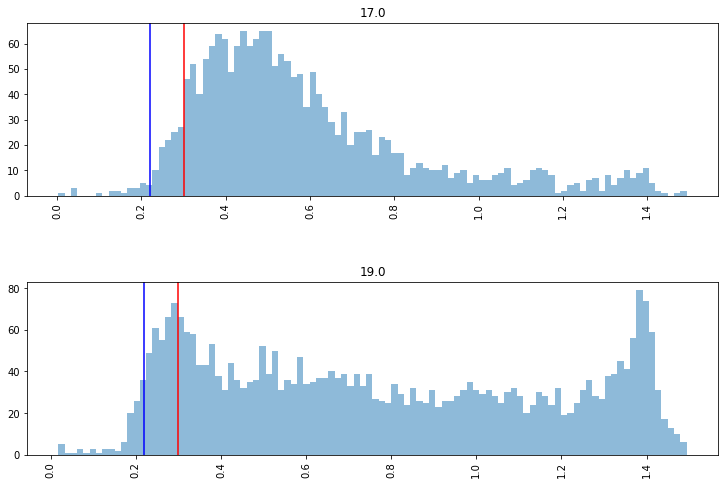

In [19]:
# Extract the data for the two apparent magnitude slices
v = (
    res2[['g', 'gr']]
    .assign(gbinned = lambda df: df.g.round())
    .query('(gbinned == 17 or gbinned == 19) and (0 < gr < 1.5)')
)
ax = v.gr.hist(by=v['gbinned'], bins=100, alpha=.5, figsize=(12, 8), layout=(2, 1))
for a in ax:
    a.axvline(0.3, color='red')
    a.axvline(0.22, color='blue')

The turnoff truly is bluer, by about 0.1 magnitudes!

This is the gist of the analysis performed to characterize the "Monoceros Stream":

![Newberg2002.jpg](figures/Newberg2002.jpg)